In [1]:
import pandas as pd
import AnalFunctions as af
import numpy as np
import matplotlib.pyplot as plt
import os

path, folder_list, N_runs, b, cross_var, folder_frame, test_str, test_var, test_var2, test_str2, lin_var, T_test_list, sec_test_var, N_ped, fps, mot_frac = af.var_ini()
af.file_writer(path, folder_list, N_runs, b, cross_var, folder_frame, test_str, test_var)

sl = "/"
T_test_list = lin_var[test_var2]
lattice_type = 'jule'
runs_tested = N_runs
traj_testvar2 = []


def dist(x1, y1, x2, y2, x3, y3): # x3,y3 is the point

    px = x2-x1
    py = y2-y1

    norm = px*px + py*py

    u =  ((x3 - x1) * px + (y3 - y1) * py) / float(norm)

    #u_new = np.array([1 if ui > 1 else 0 for ui in u])
    u[u > 1] = 1
    u[u < 0] = 0

    x = x1 + u * px
    y = y1 + u * py

    dx = x - x3
    dy = y - y3

    # Note: If the actual distance does not matter,
    # if you only want to compare what this function
    # returns to other results of this function, you
    # can just return the squared distance instead
    # (i.e. remove the sqrt) to gain a little performance

    dist = np.sqrt(dx*dx + dy*dy)
    return dist



current path is  trajectories/ini_lm_N_ped55_tmax104_size_0_17_fps_16_testvar_b/
Index(['Unnamed: 0', 'ini_folder', 'b', 'v0', 'T', 'rho', 'esigma', 'N_ped',
       'mot_frac'],
      dtype='object')
0    1.3
1    1.3
2    1.3
3    1.3
4    1.3
5    1.3
6    1.3
Name: T, dtype: float64
[1.3 1.3 1.3 1.3 1.3 1.3 1.3]
[[ 0.7   0.6   1.34  1.3   3.6  55.    1.    0.25]
 [ 0.7   0.75  1.34  1.3   3.6  55.    1.    0.25]
 [ 0.7   1.    1.34  1.3   3.6  55.    1.    0.25]
 [ 0.7   1.25  1.34  1.3   3.6  55.    1.    0.25]
 [ 0.7   1.7   1.34  1.3   3.6  55.    1.    0.25]
 [ 0.7   2.9   1.34  1.3   3.6  55.    1.    0.25]
 [ 0.7   3.5   1.34  1.3   3.6  55.    1.    0.25]]
   Unnamed: 0                                         ini_folder     b    v0  \
0           0  ini_0_6_lm_55_esigma_0_7_tmax_104_periodic_0_v...  0.60  1.34   
1           1  ini_0_75_lm_55_esigma_0_7_tmax_104_periodic_0_...  0.75  1.34   
2           2  ini_1_0_lm_55_esigma_0_7_tmax_104_periodic_0_v...  1.00  1.34   
3    

In [3]:
def add_wall(line_width,bi):
    wall1 = plt.Line2D((-bi / 2, -bi / 2), (0, 100), lw=line_width)
    wall2 = plt.Line2D((bi / 2, bi / 2), (0, 100), lw=line_width)
    wall3 = plt.Line2D((-bi / 2, -0.45), (0, 0), lw=line_width)
    wall4 = plt.Line2D((0.45, bi / 2), (0, 0), lw=line_width)
    wall5 = plt.Line2D((0.45, 0.25), (0., -0.15), lw=line_width)
    wall6 = plt.Line2D((-0.45, -0.25), (0., -0.15), lw=line_width)
    wall7 = plt.Line2D((0.25, 0.25), (-0.15, -1.0), lw=line_width)
    wall8 = plt.Line2D((-0.25, -0.25), (-0.15, -1.), lw=line_width)
    plt.gca().add_line(wall1)
    plt.gca().add_line(wall2)
    plt.gca().add_line(wall3)
    plt.gca().add_line(wall4)
    plt.gca().add_line(wall5)
    plt.gca().add_line(wall6)
    plt.gca().add_line(wall7)
    plt.gca().add_line(wall8)


In [4]:
waittime_list = []
test_var_list = []
test_var2_list = []
b_list = []
N_ped_list = []
T_list = []
os.system("mkdir " + path + "waittime")
t_min = 10
t_max = 30
t_start = t_min * fps
t_end = t_max * fps


In [5]:
from multiprocessing import Pool


In [7]:
col = ["FR","X","Y","ID","IntID"]
blist = 2 * lin_var[test_var]
v_0_list = []
from itertools import groupby
N_del_i = 10
N_del = 10
for T_test in T_test_list:
    folder_frame_frac = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['ini_folder'])
    b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['b'])
    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi, 3) + "_" + str(i) + ".txt" for i in
                 range(runs_tested)] for folder, bi in zip(folder_frame_frac, b_folder)]
    bi = 0
    for loc_list_runs in loc_list:
        print("<calculating " + test_str + " = " + str(2 * lin_var[test_var][bi]) + ">")
        p0count = 0
        count = 0
        incount = 0
        for loc in loc_list_runs:
            if os.path.isfile(loc) == False:
                #print("WARNING: file " + loc + " not found.")
                continue
            df = pd.read_csv(loc, sep="\s+", header=0, comment="#",skipinitialspace=True, usecols=col)
            n_min_frame = df.groupby('ID')['FR'].min()[df['ID']].nsmallest(N_del_i).index.values
            n_max_frame = df.groupby('ID')['FR'].max()[df['ID']].nlargest(N_del).index.values
            #df = df[~df['ID'].isin(n_min_frame)]

            df = df[~df['ID'].isin(n_max_frame)]
            #framemax = df["FR"].max()
            #print(ids)
            #print(df_fr)
            print(df["FR"].min(),df["FR"].max())
            for t in np.arange(10 * fps,df["FR"].max()):
                #print("T=",t)
                df_t = df[df['FR'] == t]
                df_id = df_t['ID'].values
                df_int = df_t['IntID'].values
                df_new = pd.DataFrame({"ID":df_id,"IntID":df_int})
                np_new = df_new.values
                set_new = [set(i) for i in np_new]
                truec = np.array([len(list(group)) for key, group in groupby(set_new)]) > 1
                truec = truec.sum()
                count += truec
                incount += df_int.shape[0]
                #print(np.array([len(list(group)) for key, group in groupby(set_new)]) > 1 )

                #print(df_new.isin(np_new))
                #print(df_new)
        print(count)
        print(incount)
        print(count/incount)
                
                
        bi += 1           

<calculating b = 1.2>
0 983
0 994
0 1031
0 1014
0 1003
0 1005


KeyboardInterrupt: 

(1, 7, 50, 1)
<calculating b = 1.2>


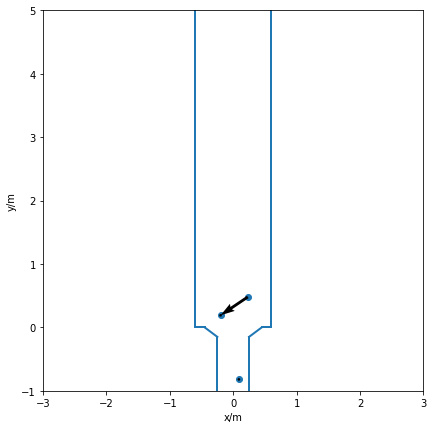

counts_mean =  0.02
<calculating b = 1.5>


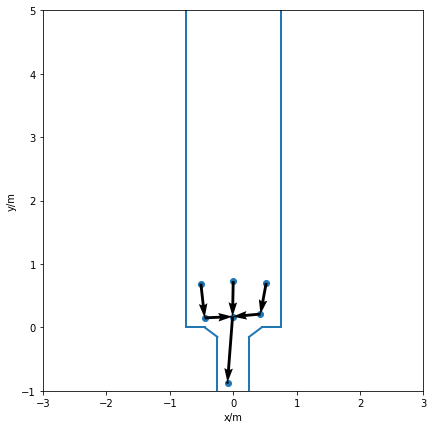

counts_mean =  0.03
<calculating b = 2.0>


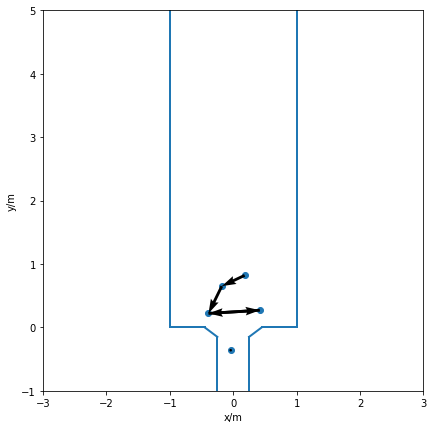

counts_mean =  0.026666666666666665
<calculating b = 2.5>


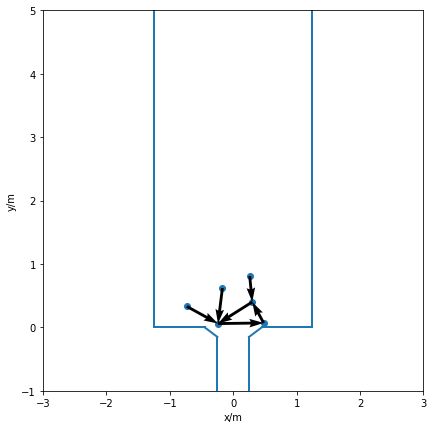

counts_mean =  0.04
<calculating b = 3.4>


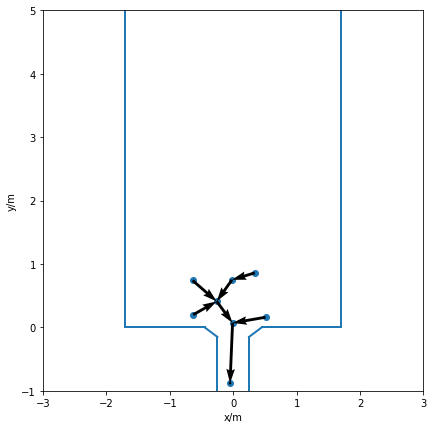

counts_mean =  0.035
<calculating b = 5.8>


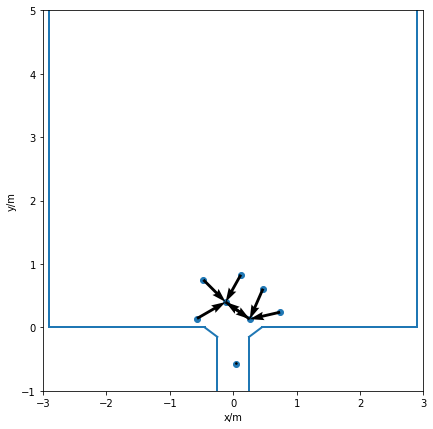

counts_mean =  0.07
<calculating b = 7.0>


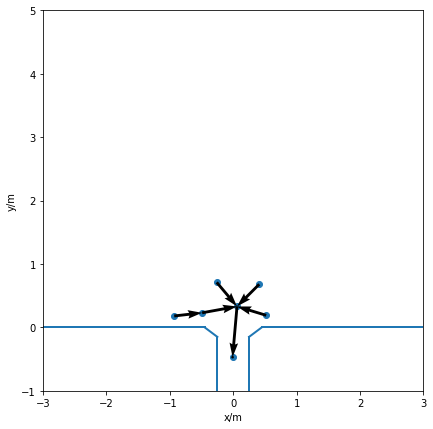

counts_mean =  0.04


In [8]:
N_del = 10
col = ["FR","X","Y","ID","IntID"]
time_cluster_T = []
os.system("mkdir " + path + "plots")
os.system("mkdir " + path + "plots/graph")
os.system("mkdir " + path + "graph")
time = np.arange(11 * fps ,11 * fps + 1 ,1)

np_cluster_array = np.empty([len(T_test_list),lin_var[test_var].shape[0],N_runs,time.shape[0]])
print(np_cluster_array.shape)

for T_test, T_i in zip(T_test_list, range(len(T_test_list))):
    folder_frame_frac = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['ini_folder'])
    b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['b'])
    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi, 3) + "_" + str(i) + ".txt" for i in
                 range(runs_tested)] for folder, bi in zip(folder_frame_frac, b_folder)]
    bi = 0
    #count_list = []
    #time_cluster = []
    for loc_list_runs, var_i in zip(loc_list,range(len(loc_list))):
        print("<calculating " + test_str + " = " + str(2 * lin_var[test_var][bi]) + ">")
        p0count = 0
        count = 0
        incount = 0
        count_mean = 0
        n_count = 50 * time.shape[0]
        #node_time = []
        for loc, l_i in zip(loc_list_runs[0:1], range(len(loc_list_runs))):
            if os.path.isfile(loc) == False:
                #print("WARNING: file " + loc + " not found.")
                continue
                
            if os.stat(loc).st_size == 0:
                #print("WARNING: file " + loc + " not found.")
                continue
            df = pd.read_csv(loc, sep="\s+", header=0, comment="#",skipinitialspace=True, usecols=col)
            #n_min_frame = df.groupby('ID')['FR'].min()[df['ID']].nsmallest(N_del_i).index.values
            n_max_frame = df.groupby('ID')['FR'].max()[df['ID']].nlargest(N_del).index.values
            #df = df[~df['ID'].isin(n_min_frame)]

            df = df[~df['ID'].isin(n_max_frame)]
            #df = df[df['Y'] > 0]
            df = df[df['X'] * df['X'] + df['Y']* df['Y'] < 1.**2]
            #framemax = df["FR"].max()
            #print(ids)
            #print(df_fr)
            #print(df["FR"].min(),df["FR"].max())
            #node_time_i = []
            for t, t_i in zip(time,range(time.shape[0])):
                xpos = []
                ypos = []
                u = []
                v = []
                df_t = df[df["FR"] == t]
                #print(df_t)
                id_list = df_t["ID"].values
                int_list = df_t[df_t["IntID"]> 0]["IntID"].values
                unique, counts = np.unique(int_list, return_counts=True)
                #print(counts.mean())
                count_mean += counts.mean()
                #node_time_i.append(counts.mean())
                np_cluster_array[T_i][var_i][l_i][t_i] = counts.mean()
                #print(id_list)
                for i in id_list:
                    df_id = df_t[df_t["ID"] == i]
                    x1 = df_id["X"].values[0]
                    x2 = df_id["Y"].values[0]
                    inter = df_id["IntID"].values[0]
                    #print(inter)
                    xpos.append([x1])
                    ypos.append([x2])
                    if inter > 0:
                        #print(inter)
                        #print(np.isin(inter,id_list))
                        df_int = df_t[df_t["ID"] == inter] 
                        #print(df_int)
                        
                        if(df_int.values.shape[0] > 0):
                            x1int = df_int["X"].values[0]
                            x2int = df_int["Y"].values[0]
                            u.append(x1int - x1)
                            v.append(x2int - x2)
                        else:
                            u.append(0)
                            v.append(0)
                    else:
                        u.append(0)
                        v.append(0)
            
            fig, ax = plt.subplots(figsize = (12, 7))
            plt.scatter(xpos,ypos)
            ax.quiver(xpos, ypos, u, v,angles='xy', scale_units='xy',scale = 1)
            ax.set_aspect("equal")
            ax.axis([-3, 3, -1, 5])
            plt.xlabel("x/m")
            plt.ylabel("y/m")
            add_wall(2,2 * lin_var[test_var][bi])
            plt.savefig(path + 'plots/graph/graph_' + af.b_data_name(2 * lin_var[test_var][bi],3) + '.pdf')
            #show plot 
            plt.show() 
            #node_time.append(node_time_i)
        #np_time = np.array(node_time)
            
        #print(np_time.shape)
        #time_cluster.append(np_time.mean(axis=0))
        #plt.plot(time/fps,np_cluster_array[T_i][var_i].mean(axis=0),label = "b = " + str(2 * lin_var[test_var][bi]))
        bi += 1
            
        print("counts_mean = ", count_mean/n_count)
    
    #np.save(path + "cluster" + af.b_data_name(T_test,3) + ".npy", np_cluster_array)
    #count_list.append(count_mean/n_count)
    #time_cluster_T.append(time_cluster)
    #print(time_cluster_T.shape)
    #plt.legend()
    #plt.show()
    #plt.plot(2 * lin_var[test_var],count_list)
                    
                            

(0,)
[]


ValueError: x and y must be the same size

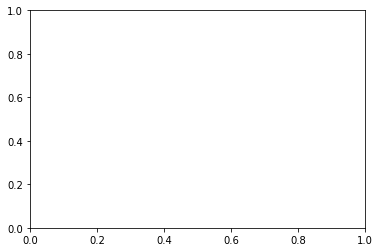

In [9]:
plt.show()
np_time_cluster = np.array(time_cluster_T)
print(np_time_cluster.shape)
#print(np_time_cluster)
max_clust = []
#print(np_time_cluster.shape)
#print(np_time_cluster)
for clust in np_time_cluster:
    #print(clust.shape)
    #print(clust)
    ##print(clust)
   # print("a")
    #print(clust.max())
    max_clust.append(clust.max())
print(max_clust)
plt.scatter(2 * lin_var[test_var],max_clust)
np_time_cluster.mean(axis = 1)[0].max()
#plt.plot(np_time_cluster.mean(axis = 1))

(1, 7, 50, 1441)
<calculating b = 1.2>
<calculating b = 1.5>


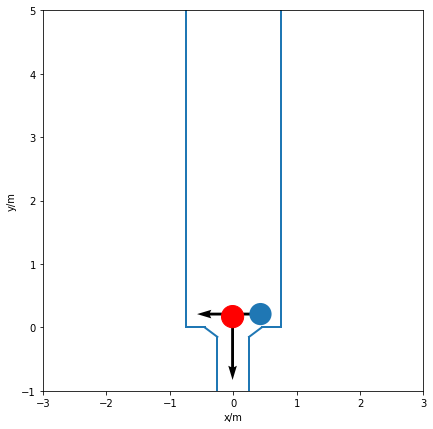

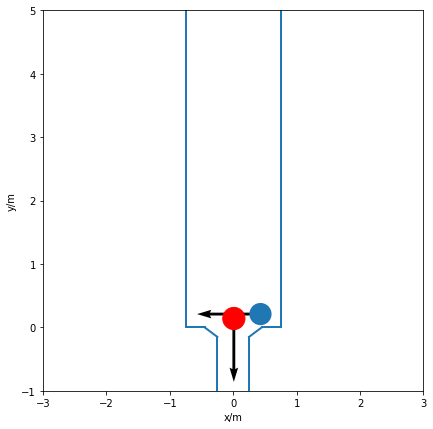

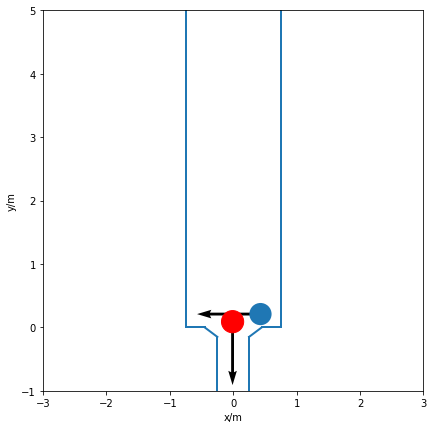

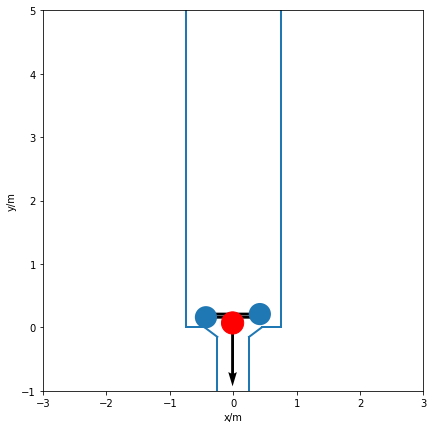

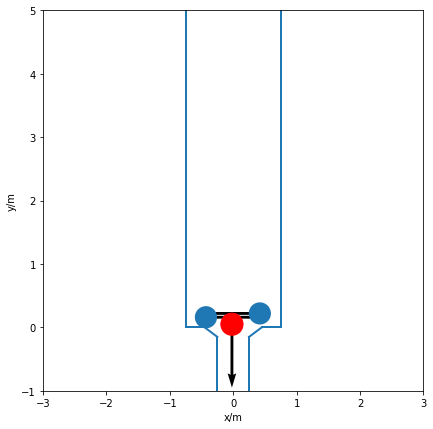

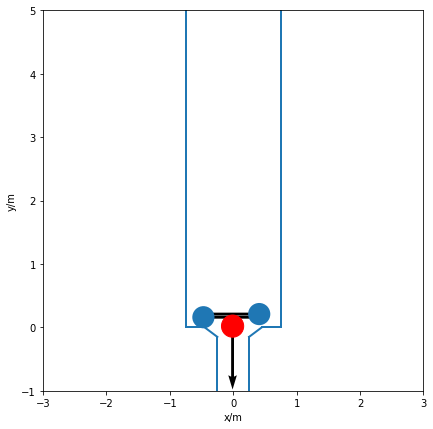

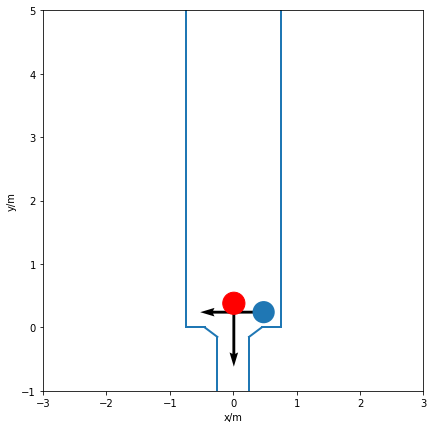

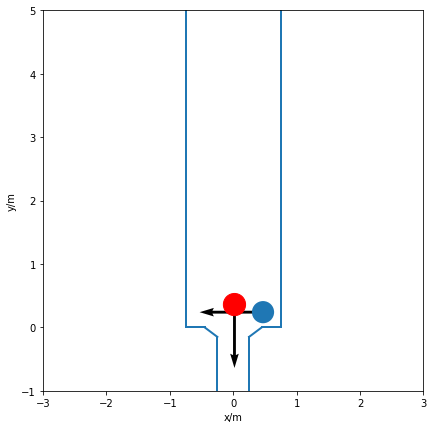

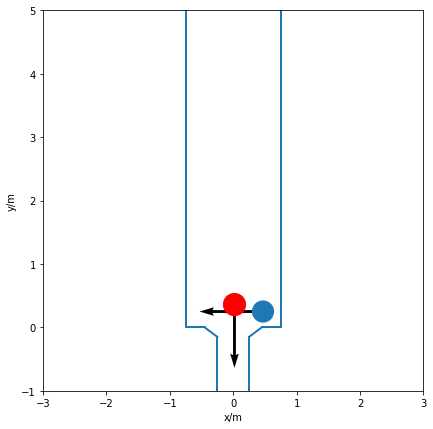

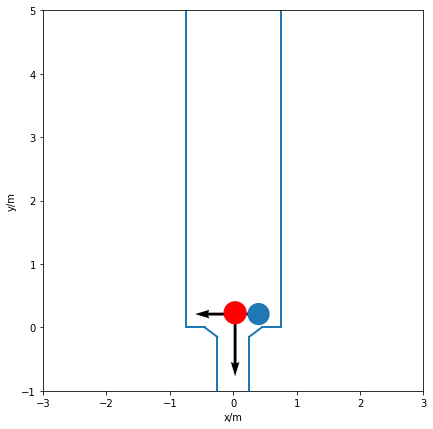

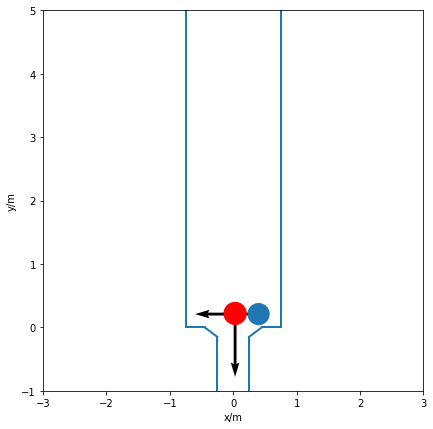

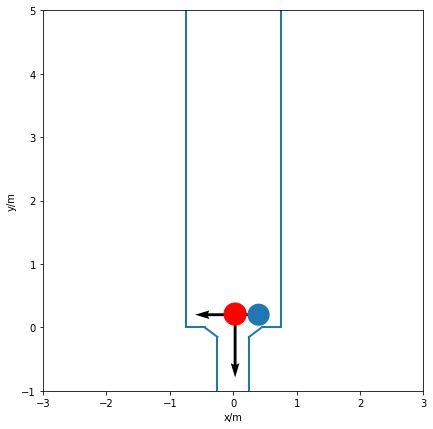

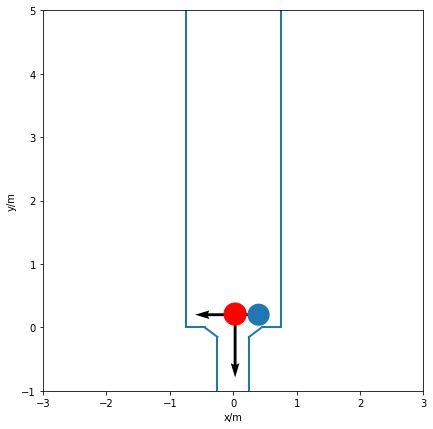

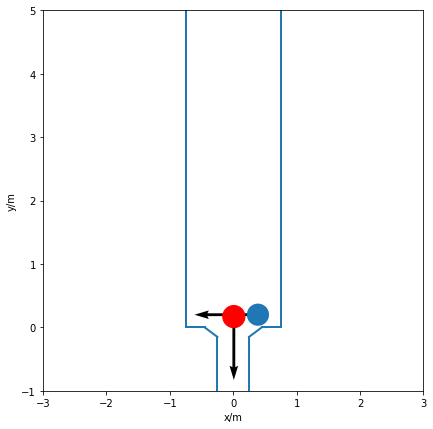

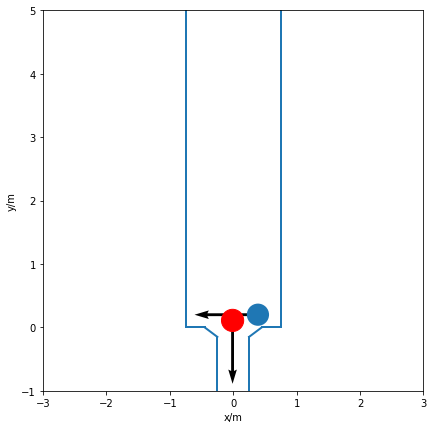

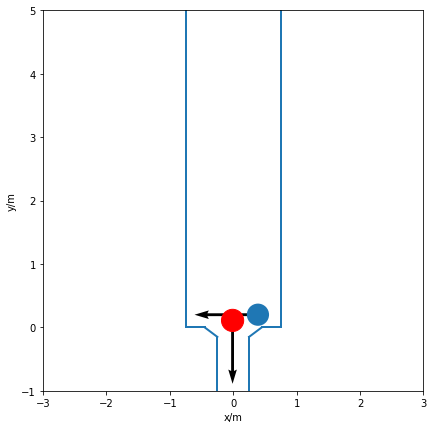

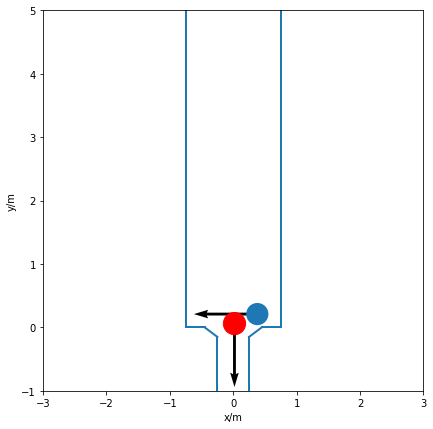

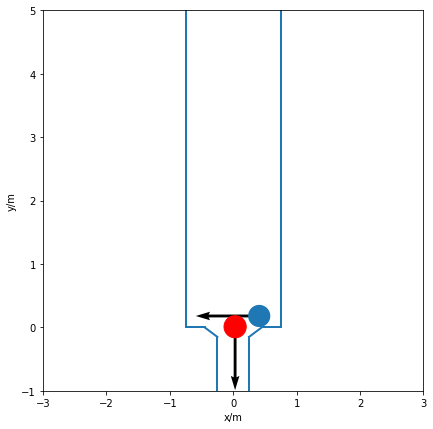

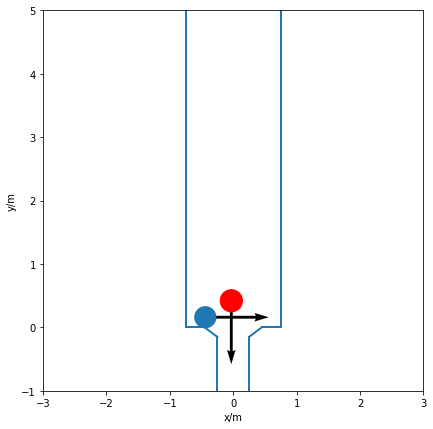

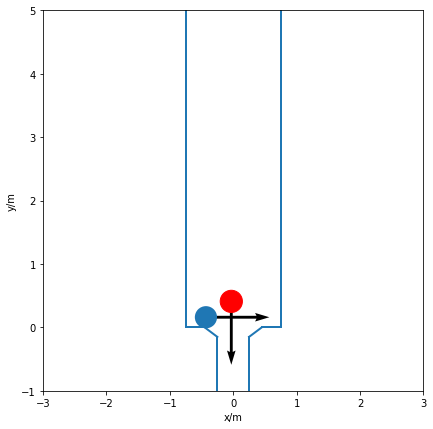

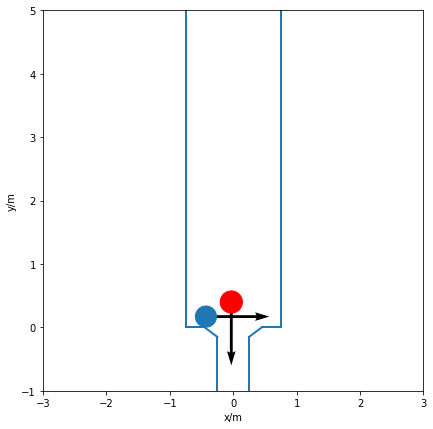

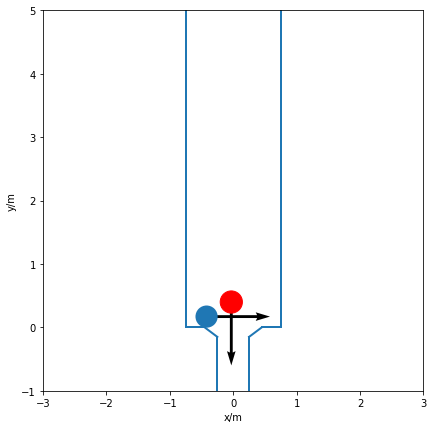

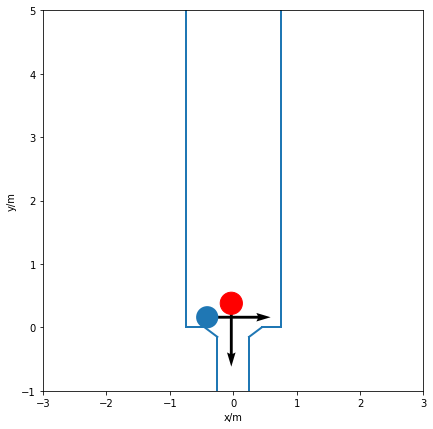

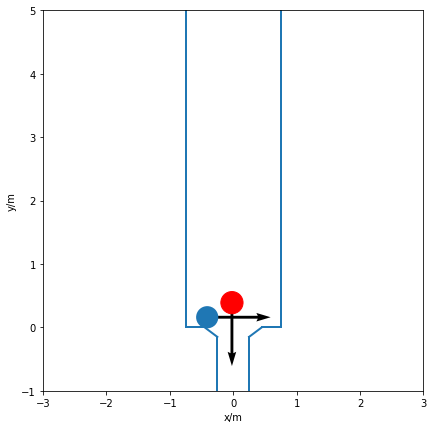

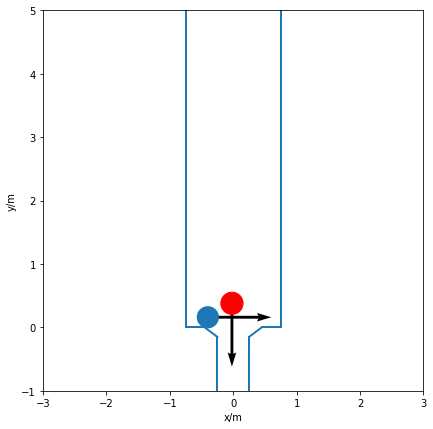

<calculating b = 2.0>


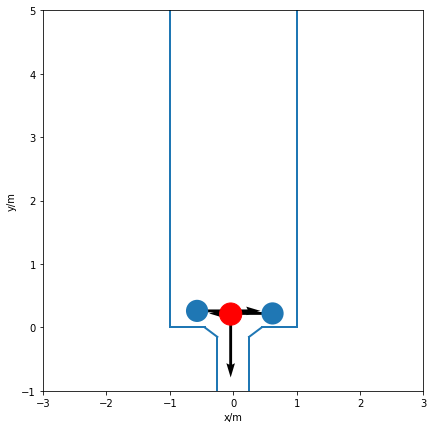

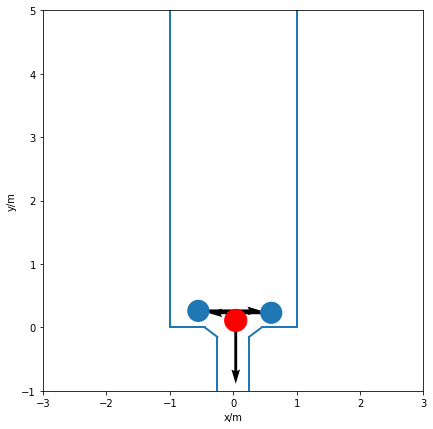

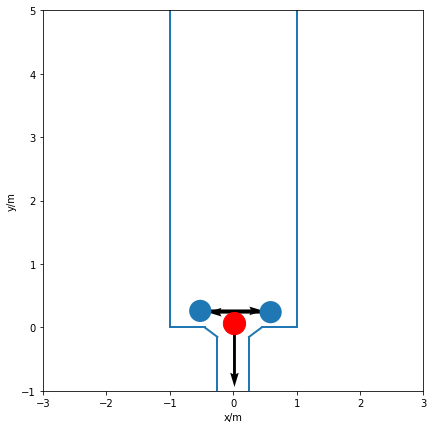

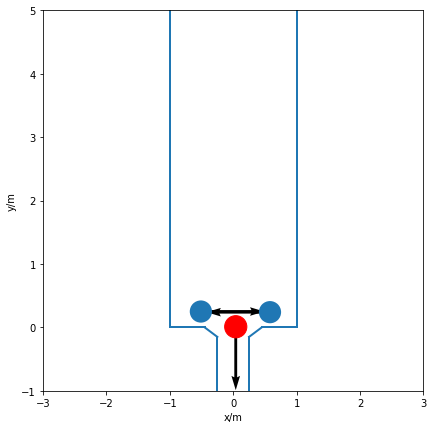

<calculating b = 2.5>
<calculating b = 3.4>


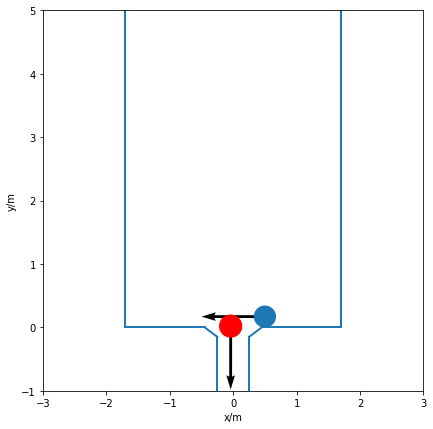

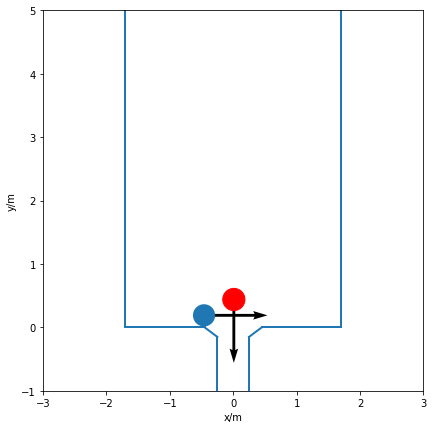

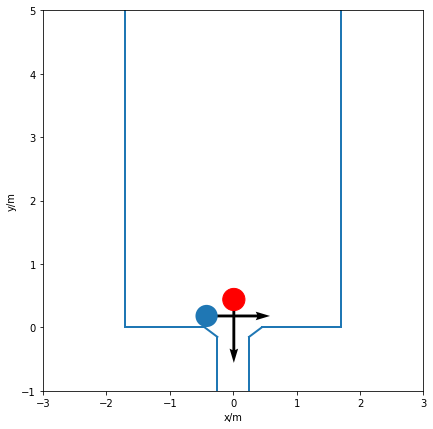

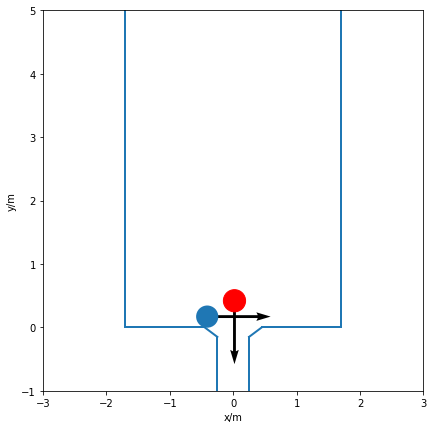

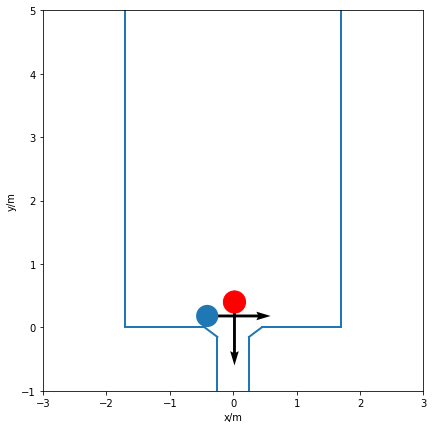

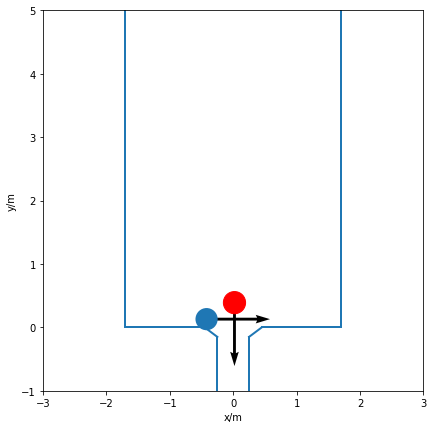

<calculating b = 5.8>


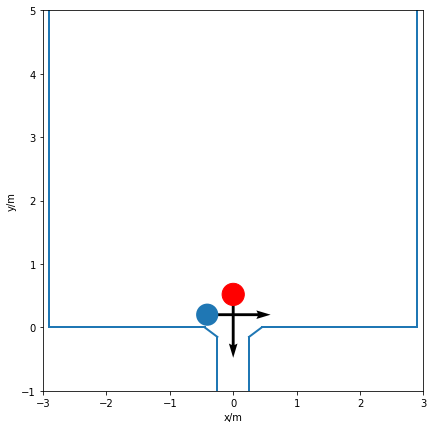

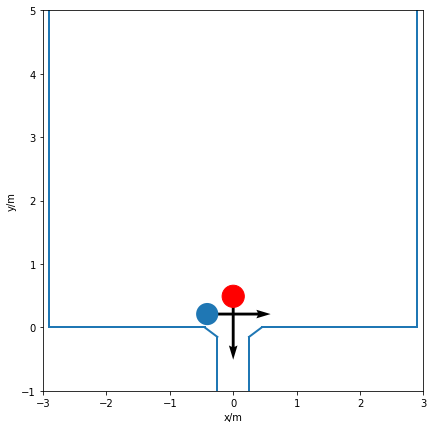

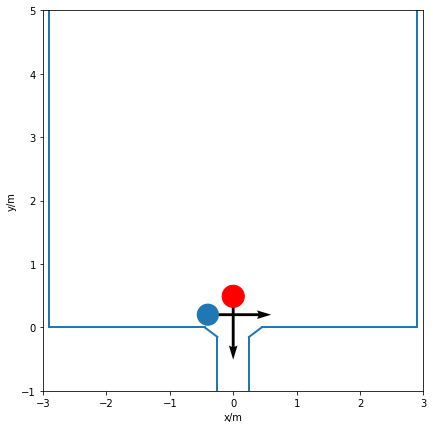

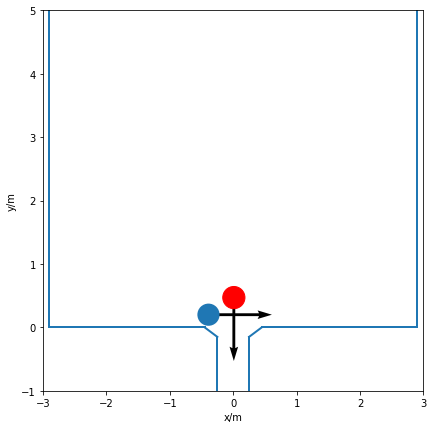

<calculating b = 7.0>


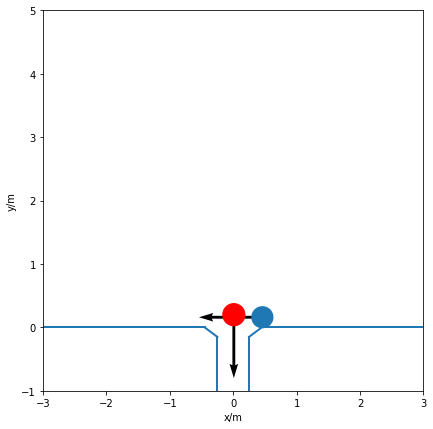

In [24]:
N_del = 10
import matplotlib as mpl

col = ["FR","X","Y","ID","IntID","AngleDirNn","ANGLE_int_nn"]
time_cluster_T = []

time = np.arange(10 * fps ,100 * fps + 1 ,1)

np_cluster_array = np.empty([len(T_test_list),lin_var[test_var].shape[0],N_runs,time.shape[0]])
print(np_cluster_array.shape)

for T_test, T_i in zip(T_test_list, range(len(T_test_list))):
    folder_frame_frac = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['ini_folder'])
    b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['b'])
    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi, 3) + "_" + str(i) + ".txt" for i in
                 range(runs_tested)] for folder, bi in zip(folder_frame_frac, b_folder)]
    bi = 0
    #count_list = []
    #time_cluster = []
    for loc_list_runs, var_i in zip(loc_list,range(len(loc_list))):
        print("<calculating " + test_str + " = " + str(2 * lin_var[test_var][bi]) + ">")

        #node_time = []
        for loc, l_i in zip(loc_list_runs[0:1], range(len(loc_list_runs))):
            if os.path.isfile(loc) == False:
                #print("WARNING: file " + loc + " not found.")
                continue
                
            if os.stat(loc).st_size == 0:
                #print("WARNING: file " + loc + " not found.")
                continue
            df = pd.read_csv(loc, sep="\s+", header=0, comment="#",skipinitialspace=True, usecols=col)
            n_max_frame = df.groupby('ID')['FR'].max()[df['ID']].nlargest(N_del).index.values

            df = df[~df['ID'].isin(n_max_frame)]
            df = df[df['IntID']>0]
           
            df = df[df['Y']>0]
            df = df[df['X'] * df['X'] + df['Y']* df['Y'] < 1.**2]
            df = df[df["FR"]>10 * fps]
            framemax = df["FR"].max()
            framemin = df["FR"].min()
            #time = np.arange(framemin,framemax)
            time = np.arange(11 * fps, 20 * fps + 1)
            #print(time)
            scalarprod = np.empty(0)
            angles = np.empty(0)
            for t, t_i in zip(time,range(time.shape[0])):
                
                df_t = df[df["FR"] == t]

                #print(df_t)
                ids = df_t['ID'].values
                
                for ID in ids:
                    df_int = df_t[df_t["IntID"] == ID]
                    df_id = df_t[df_t["ID"] == ID]
                    scalarprduct = df_int["ANGLE_int_nn"].values
                    if 0. in scalarprduct:
                        fig, ax = plt.subplots(figsize = (12, 7))

                        df_int = df_int[df_int["ANGLE_int_nn"] == 0.]
                        dirphi = df_int["AngleDirNn"].values
                        x_dirint = np.cos(dirphi)
                        y_dirint = np.sin(dirphi)
                        x_pos = df_int["X"].values
                        y_pos = df_int["Y"].values
                        for xi,yi in zip(x_pos,y_pos):
                            circle = plt.Circle((xi, yi), 0.175)
                            ax.add_artist(circle)
                            
                        x_id = df_id["X"].values
                        y_id = df_id["Y"].values
                        dirphi = df_id["AngleDirNn"].values
                        x_dir = np.cos(dirphi)
                        y_dir = np.sin(dirphi)
                        circle = plt.Circle((x_id, y_id), 0.175,color = "r")
                        ax.add_artist(circle)

                        plt.scatter(x_pos,y_pos)
                        ax.quiver(x_pos, y_pos, x_dirint, y_dirint,angles='xy', scale_units='xy',scale = 1)
                        
                        plt.scatter(x_id,y_id)
                        ax.quiver(x_id, y_id, x_dir, y_dir,angles='xy', scale_units='xy',scale = 1)

                        ax.set_aspect("equal")
                        ax.axis([-3, 3, -1, 5])
                        plt.xlabel("x/m")
                        plt.ylabel("y/m")
                        add_wall(2,2 * lin_var[test_var][bi])
                        plt.show()
                            
                    #x_dir = np.cos(df_id["AngleDirNn"].values)
                    #y_dir = np.sin(df_id["AngleDirNn"].values)
                    #scp = df_id["ANGLE_int_nn"]
                    #angledir = df_int["ANGLE_int_nn"].values
                    #scprod = np.arccos(x_dir * x_dirint + y_dir*y_dirint) * 180/3.1415
                    
                    #print((np.arccos(angledir) * 180/3.1415 , scprod) )
                    #print(np.arccos(x_dir * x_dirint + y_dir*y_dirint) * 180/3.1415)
                    #scalarprod = np.append(scalarprod,np.arccos(x_dir * x_dirint + y_dir*y_dirint) * 180/3.1415)
                    #angles = np.append(angles,np.arccos(angledir) * 180/3.1415)
                    #print(scalarprod)
                    
                    #print(x_pos)
                    """plt.scatter(x_pos,y_pos)
                    ax.quiver(x_pos, y_pos, x_dirint, y_dirint,angles='xy', scale_units='xy',scale = 1)
                    ax.set_aspect("equal")
                    ax.axis([-3, 3, -1, 5])
                    plt.xlabel("x/m")
                    plt.ylabel("y/m")
                    add_wall(2,2 * lin_var[test_var][bi])
                plt.show() """
            bi += 1

        #plt.hist(scalarprod,bins = 50,density = True)
        #plt.hist(angles,bins=50,density = True)
                


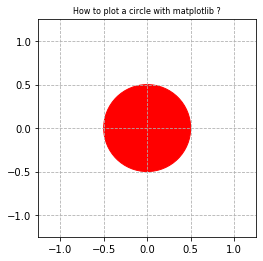

In [154]:
circle1 = plt.Circle((0, 0), 0.5, color='r')

fig, ax = plt.subplots()

plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)

plt.grid(linestyle='--')

ax.set_aspect(1)

ax.add_artist(circle1)

plt.title('How to plot a circle with matplotlib ?', fontsize=8)

plt.savefig("plot_circle_matplotlib_02.png", bbox_inches='tight')

plt.show()

In [272]:
time = np.arange(1 * fps,20 * fps,int(fps/2))
print(time.shape)
print(np_time.mean(axis=0))

(38,)
[1.41411335 1.41984835 1.42756026 1.40882294 1.42315511 1.43620332
 1.41041568 1.39825077 1.39136307 1.40210916 1.39240947 1.37283971
 1.3829085  1.40337033 1.41893777 1.38153773 1.39193972 1.38255921
 1.38674971 1.40306866 1.41794411 1.43709663 1.41592889 1.39820633
 1.39849841 1.40449542 1.42204969 1.4094422  1.40157852 1.40520833
 1.39827448 1.41453065 1.38821889 1.39933471 1.40467    1.38932624
 1.39170536 1.38951951]


In [75]:
os.system("mkdir " + path  + "distributions")


0

<calculating b = 1.0>
0


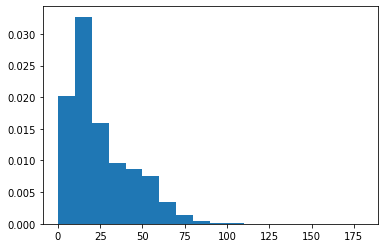

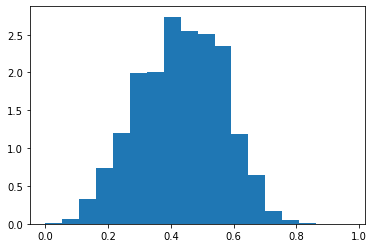

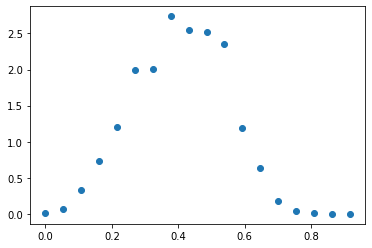

0.4312603274173807
24.691655944226227
<calculating b = 1.2>
1


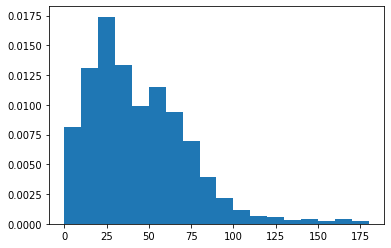

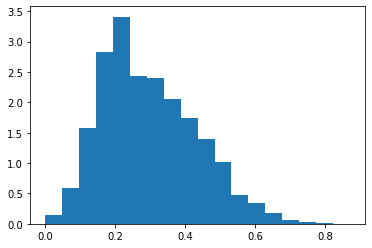

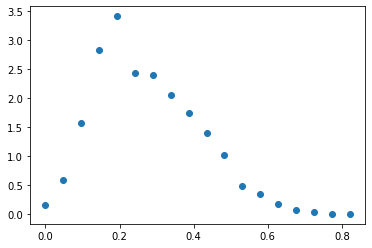

0.2962320879721331
44.07550604877028
<calculating b = 1.5>
37


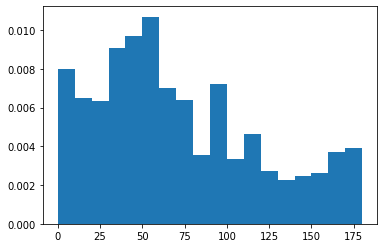

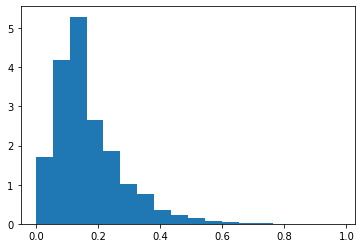

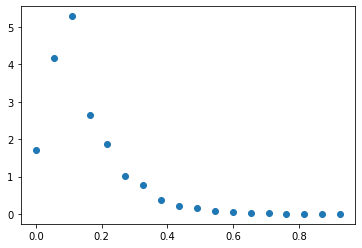

0.16658746019545406
70.99786359566774
<calculating b = 2.0>
46


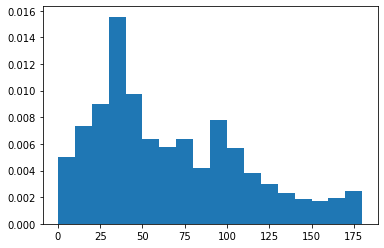

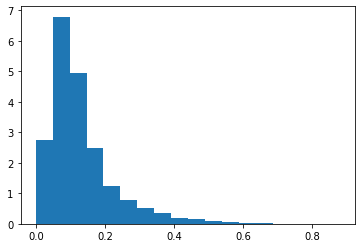

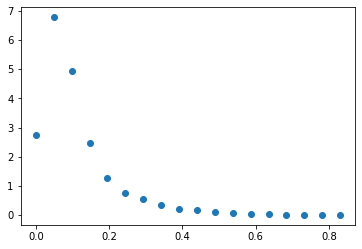

0.12806028264442643
66.50203362879041
<calculating b = 2.3>
44


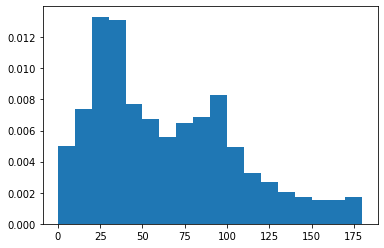

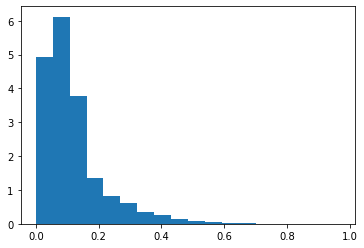

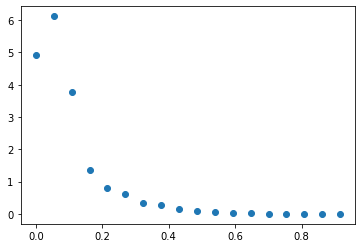

0.11725812301598766
64.08885911568574
<calculating b = 3.0>
43


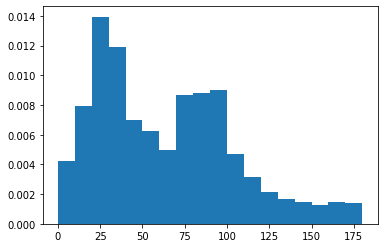

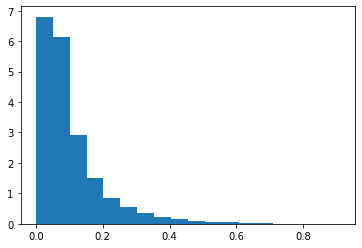

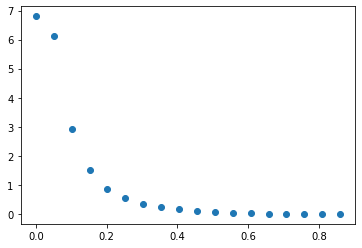

0.10665163064245962
63.7237128859495
<calculating b = 3.4>
44


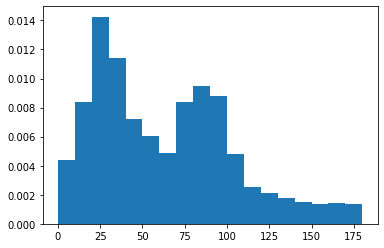

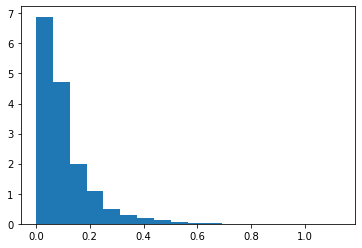

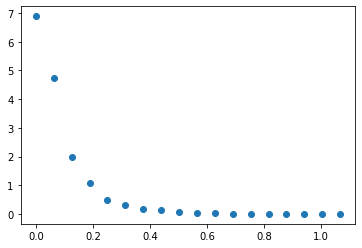

0.10519195362332057
63.32094650038012
<calculating b = 4.5>
43


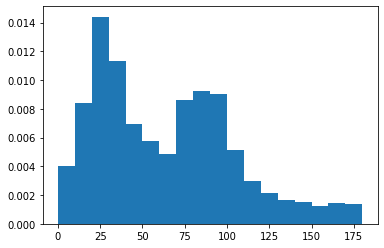

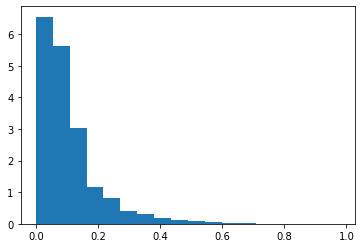

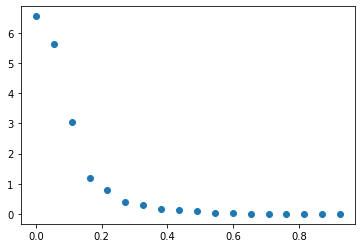

0.10425506757745509
63.72256705145545
<calculating b = 5.8>
48


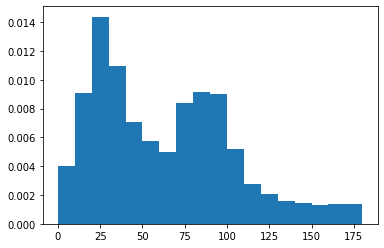

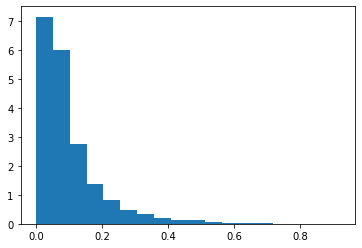

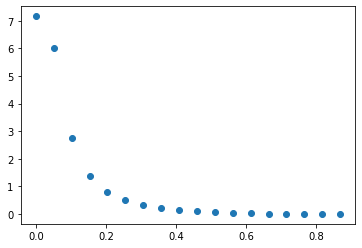

0.1028231513659064
63.34162057272273
<calculating b = 7.0>
42


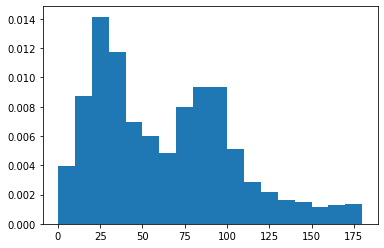

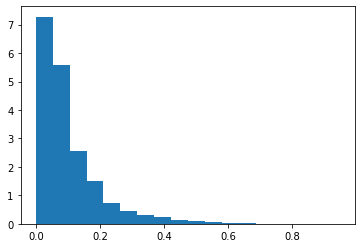

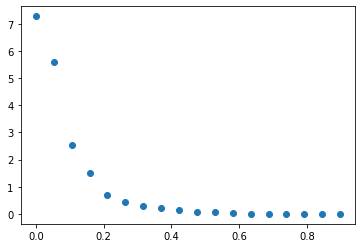

0.10186199978731171
63.36287911197322


In [117]:
col = ["FR","X","Y","ID","speed_nn","ANGLE_int_nn"]
blist = 2 * lin_var[test_var]
v_0_list = []
resultfolder = "distributions/"
os.system("mkdir " + path  + resultfolder)
os.system("mkdir " + path  + "plots")
os.system("mkdir " + path  + "plots/angledist")
os.system("mkdir " + path  + "plots/speeddist")

folderlist = []
for T_test in T_test_list:
    folder_frame_frac = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['ini_folder'])
    b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['b'])

    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi, 3) + "_" + str(i) + ".txt" for i in
                 range(runs_tested)] for folder, bi in zip(folder_frame_frac, b_folder)]
    bi = 0
    
    v_0_mean = np.empty(blist.shape[0])
    v_0_var = np.empty(blist.shape[0])
    angle_nn_var = np.empty(blist.shape[0])
    angle_nn_mean = np.empty(blist.shape[0])
    for loc_list_runs in loc_list:
        print("<calculating " + test_str + " = " + str(2 * lin_var[test_var][bi]) + ">")
        v_nn_mean = np.empty(0)
        angle_nn = np.empty(0)
        p0count = 0
        for loc in loc_list_runs:
            if os.path.isfile(loc) == False:
                #print("WARNING: file " + loc + " not found.")
                continue
            df = pd.read_csv(loc, sep="\s+", header=0, comment="#",skipinitialspace=True, usecols=col)
            #df['ANGLE_int_nn'] = df['ANGLE_int_nn'].values.astype(np.float)
            df = df[df['FR'] > 10 * fps]
            df = df[df['ANGLE_int_nn'].values.astype(np.float) >= -1.0]
            df = df[df['speed_nn'].values.astype(np.float) >= 0.0]
            df = df[df['speed_nn'].values.astype(np.float) < 1.34]
            p0 = df.groupby('FR')['speed_nn'].max()
            p0 = p0[p0.values < 0.1].values.shape[0]
            #print(p0)
            if p0 > 0:
                p0count += 1
            
            #print(p0)
            #df = df[df['FR'] > fps * 10]
            df = df[df['Y'] > 0]
            df = df[df['X'] * df['X'] + df['Y']* df['Y'] < 1.**2]
            v_nn_mean = np.append(v_nn_mean,df['speed_nn'].values.astype(np.float))  
            #df = df[abs(df['X']) < 0.5]
            #df = df[df['Y'] > 1]

            #df = df[df['Y'] < 1]

            angle_nn = np.append(angle_nn,np.arccos(df['ANGLE_int_nn'].values.astype(np.float))*180./3.1415)
        print(p0count)
        #plt.hist(v_nn_mean,bins=50)
        #plt.show()
        df_anal = pd.DataFrame({"angle":angle_nn,"speed" : v_nn_mean})
        dat_name = path + resultfolder + "dist_" + af.b_data_name(2 * lin_var[test_var][bi],3) + ".csv"
        df_anal.to_csv(dat_name)
        x, bins, p= plt.hist(angle_nn,bins=18,density=True)
        plt.savefig(path + 'plots/angledist/angle_' + af.b_data_name(2 * lin_var[test_var][bi], 3) + '.png')
        plt.show()

        x, bins, p =plt.hist(v_nn_mean,bins = 18,density=True)
        plt.savefig(path + 'plots/speeddist/speed_' + af.b_data_name(2 * lin_var[test_var][bi], 3) + '.png')

        plt.show()

        nphist = np.histogram(v_nn_mean,bins=18,density = True)
        #plt.plot(nphist[1][:-1],np.log(-np.log(1-nphist[0])), marker = "o", linestyle='none')
        plt.plot(nphist[1][:-1],nphist[0], marker = "o", linestyle='none')
        #plt.xscale("log")
        #plt.yscale("log")
        plt.show()
        #print(v_nn_mean)
        v_0_list.append(v_nn_mean.mean())
        v_0_mean[bi] = v_nn_mean.mean()
        v_0_var[bi] = v_nn_mean.std()
        print(v_nn_mean.mean())
        angle_nn_mean[bi] = angle_nn.mean()
        angle_nn_var[bi] = angle_nn.std()

        print(angle_nn.mean())
        bi += 1
        #print(v_nn_mean.mean())


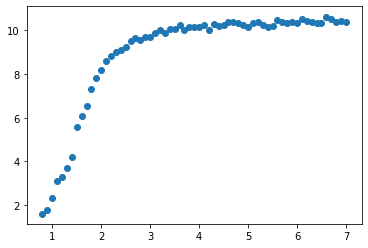

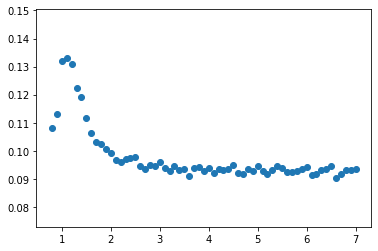

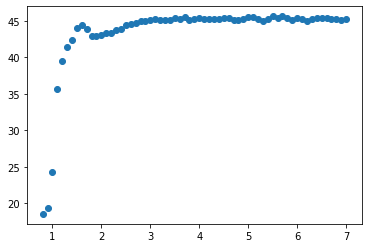

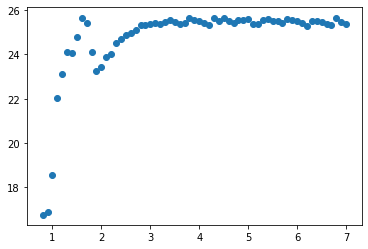

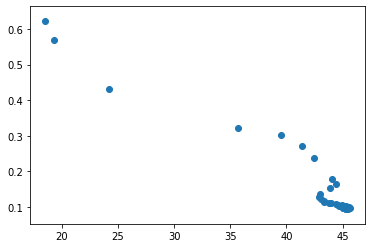

In [72]:
#plt.yscale("exp")
#plt.xscale("log")
plt.scatter(blist,1/v_0_mean)

plt.show()

plt.scatter(blist,v_0_var)
plt.show()
plt.scatter(blist,angle_nn_mean)
plt.show()

plt.scatter(blist,angle_nn_var)
plt.show()

plt.scatter(angle_nn_mean,v_0_mean)

plt.show()


<calculating b = 0.55>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


</calculating b = 0.55>


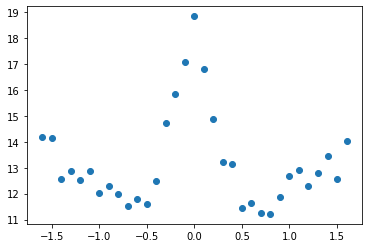

In [45]:
col = ["FR","X","Y","ID"]
t_array = np.arange(t_start, 100 * fps, int(fps/2 ))#
for T_test in T_test_list[0:1]:
    folder_frame_frac = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['ini_folder'])
    b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['b'])

    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi, 3) + "_" + str(i) + ".txt" for i in
                 range(runs_tested)] for folder, bi in zip(folder_frame_frac, b_folder)]
    bi = 0
    ttt_arr = np.empty(0)
    dist_arr = np.empty(0)
    angle_arr = np.empty(0)
    x_ar = np.empty(0)
    y_ar = np.empty(0)
    for loc_list_runs in loc_list[-2:-1]:
        print("<calculating " + test_str + " = " + str(lin_var[test_var][bi]) + ">")

        for loc in loc_list_runs:
            df = pd.read_csv(loc, sep="\s+", header=0, comment="#",skipinitialspace=True, usecols=col)
            min_value = df.groupby('ID')['Y'].min()[df['ID']][0:N_ped - 1]
            #n_max_frame = df.groupby('ID')['FR'].max()[df['ID']][0:N_ped - 1].nlargest(12).index.values
            #print(n_max_frame)
            min_value = min_value[min_value < -0.2]
            key_filtered = min_value.keys().values
            
            df = df[df['ID'].isin(key_filtered)]
            df = df[df['Y'] > 0.]
            df = df[~df['ID'].isin(n_max_frame)]
            
            max_frame = df.groupby('ID')['FR'].max()[df['ID']]
            #print(max_frame.groupby('ID').nlargest(1))
            df['max_frame'] = max_frame.values
            df = df[df['FR'].isin(t_array)]

            #print(max_frame)


            x = df['X'].values
            y = df['Y'].values
            #dist_ttt = np.round(dist(-0.4, 0., 0.4, 0., x, y),2)
            dist_ttt = np.round(np.sqrt( x * x + y * y),1)
            angle_ttt = np.round(np.arctan(y/x),1)
            ttt = df['max_frame'].values - df['FR'].values
            ttt_arr = np.append(ttt_arr,ttt)
            dist_arr = np.append(dist_arr,dist_ttt)
            angle_arr = np.append(angle_arr,angle_ttt)
            x_ar = np.append(x_ar,x)
            y_ar = np.append(y_ar,y)
        print("</calculating " + test_str + " = " + str(lin_var[test_var][bi]) + ">")
        #print(dist_ttt.shape)
        #print(ttt.shape)
        #print(np.array(ttt_arr))
        df_plot = pd.DataFrame({"ttt" :  ttt_arr  / fps,"angle":angle_arr, "dist": dist_arr,"x":x_ar,"y":y_ar })
        #plt.plot(dist_arr,ttt_arr/fps,marker = "o",linestyle='none')
        #print(df_plot)
        #print(df_plot)
        bi += 1
        df_mean = df_plot[df_plot["dist"] < 1.2]
        df_mean = df_mean[df_mean["dist"] > 1.0]

        df_mean = df_mean.groupby("angle").mean()
        #print(df_mean)
        plt.plot(df_mean.index,df_mean["ttt"],marker = "o",linestyle='none')
        #plt.xscale('log')
        #plt.yscale('log')
        plt.show()
        #plt.plot(df_plot["dist"].values, ttt_mean_list,marker = "o",linestyle='none')
   # plt.show()


In [35]:
"""theta = df_plot['angle'].values
r = df_plot['dist'].values
ttt = df_plot['ttt'].values

x_arr = r * np.cos(theta)
y_arr = r * np.sin(theta)

x, y = np.meshgrid(x_arr, y_arr)
ttt_mesh = np.meshgrid(ttt,ttt)
z = ttt_mesh[:-1, :-1].flatten()

z_min, z_max = np.abs(z).min(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='hot', vmin=z_min, vmax=12, label="density in [m^-2]")
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax, label="$\\rho$ in [$m^{-2}$]")
print(z.mean())
print("corridor width = ", bi)
if bi == 1.7 or bi == 1.2:
    print("density jump")
line_width = 2.5
add_wall(line_width,bi*2)
name_var = lin_var[test_var][test_var_count]
test_var_count += 1"""

'theta = df_plot[\'angle\'].values\nr = df_plot[\'dist\'].values\nttt = df_plot[\'ttt\'].values\n\nx_arr = r * np.cos(theta)\ny_arr = r * np.sin(theta)\n\nx, y = np.meshgrid(x_arr, y_arr)\nttt_mesh = np.meshgrid(ttt,ttt)\nz = ttt_mesh[:-1, :-1].flatten()\n\nz_min, z_max = np.abs(z).min(), np.abs(z).max()\nfig, ax = plt.subplots()\nc = ax.pcolormesh(x, y, z, cmap=\'hot\', vmin=z_min, vmax=12, label="density in [m^-2]")\n# set the limits of the plot to the limits of the data\nax.axis([x.min(), x.max(), y.min(), y.max()])\nfig.colorbar(c, ax=ax, label="$\\rho$ in [$m^{-2}$]")\nprint(z.mean())\nprint("corridor width = ", bi)\nif bi == 1.7 or bi == 1.2:\n    print("density jump")\nline_width = 2.5\nadd_wall(line_width,bi*2)\nname_var = lin_var[test_var][test_var_count]\ntest_var_count += 1'

In [36]:
"""df_plot['x']= np.round(x_arr,1)
df_plot['y']= np.round(y_arr,1)
df_heat = pd.DataFrame({"x":np.round(x_arr,1),"y":np.round(y_arr,1),"ttt":ttt_arr/fps})"""

'df_plot[\'x\']= np.round(x_arr,1)\ndf_plot[\'y\']= np.round(y_arr,1)\ndf_heat = pd.DataFrame({"x":np.round(x_arr,1),"y":np.round(y_arr,1),"ttt":ttt_arr/fps})'

In [46]:
x_arr = np.round(np.arange(-3.5,3.5,0.1),1)
y_arr = np.round(np.arange(0,10,0.1),1)


In [56]:
ttt_arr = np.zeros([y_arr.shape[0],x_arr.shape[0]])
df_plot2 = df_plot
df_plot2['x'] = np.round(df_plot2['x'].values,1)
df_plot2['y'] = np.round(df_plot2['y'].values,1)

x_i = 0
for x in x_arr:
    y_i = 0
    for y in y_arr:
        x_bool = df_plot2['x'] == x
        df_new = df_plot2[x_bool]
        y_bool = df_new['y'] == y

        df_new = df_new[y_bool]
        #print(df_new['ttt'].values.shape[0])
        if (df_new['ttt'].values.shape[0]  and x*x + y*y < 4 and x*x + y * y > 0.09):
            ttt_arr[y_i][x_i] += df_new['ttt'].values.sum()/df_new['ttt'].values.shape[0]
            
        y_i += 1
    x_i += 1


In [57]:
print(x_arr.shape,y_arr.shape)
ttt_arr.shape

(70,) (100,)


(100, 70)

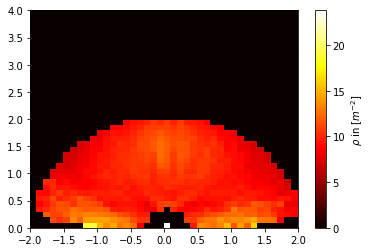

In [58]:
x, y = np.meshgrid(x_arr, y_arr)

r = x * x + y * y


z = np.divide(ttt_arr,r, where= r != 0)

#z = ttt_arr
#z = r
#print(z[z > 0])
z_min, z_max = np.abs(z).min(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='hot', vmin=z_min, vmax=z_max, label="density in [m^-2]")
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
plt.xlim([-2,2])
plt.ylim([0,4])
fig.colorbar(c, ax=ax, label="$\\rho$ in [$m^{-2}$]")
#print(z.mean())
#print("corridor width = ", bi)
#if bi == 1.7 or bi == 1.2:
#    print("density jump")
#line_width = 2.5
#add_wall(line_width,bi*2)
#name_var = lin_var[test_var][test_var_count]
#test_var_count += 1